# Tutorial: data integration for multi-omics simulated data from scMultiSim

In this tutorial, we apply FGOT to integrate simulated multi-omics data generated from scMultiSim package. The generation and preprocess code can be found from FGOT-master/preprocess/ section. After preprocessing, the data used in this experiment can be downloaded from the website (https://drive.google.com/drive/folders/19LtjMClqOJSDi50IOfPce99DOuPcWrs4). 

## load package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
import FGOT
from FGOT import preprocess as pre
from FGOT.fgot import fgot_sparse_tensor, fgot_tol, align

## load data

In [ ]:
data_path = "/home/nas2/biod/yangchenghui/FGOT-master/data/multi-omics_simulated_data/"
RNA_data = pd.read_csv(data_path+'normalized_rna_data.txt', sep=',', index_col=0)
ATAC_data = pd.read_csv(data_path+'normalized_atac_data.txt', sep=',', index_col=0)

RNA_cluster = pd.read_csv(data_path+'celltype_info.txt', sep='\t')
RNA_cluster = RNA_cluster.reset_index(drop=True)
RNA_cluster = RNA_cluster.rename(columns={"cell_id": "cell", "celltype":"cluster"})

ATAC_cluster = RNA_cluster.copy()

In [4]:
RNA_cluster

,cell,cluster
0,type1_cell1,celltype1
1,type1_cell2,celltype1
2,type1_cell3,celltype1
3,type1_cell4,celltype1
4,type1_cell5,celltype1
...,...,...
296,type4_cell296,celltype4
297,type4_cell297,celltype4
298,type4_cell298,celltype4
299,type4_cell299,celltype4


In [5]:
X1 = ATAC_data.T
X2 = RNA_data.T
(n1, d1) = X1.shape
(n2, d2) = X2.shape
print("Dimensions of input datasets are: ", "X1 = ", X1.shape, " X2 = ", X2.shape)
basic_labels1 = np.array(ATAC_cluster['cluster'])
basic_labels2 = np.array(RNA_cluster['cluster'])
print("Dimensions of basic_labels are: ", "basic_labels1 = ", basic_labels1.shape, " basic_labels2 = ", basic_labels2.shape)
cell_names1 = list(ATAC_data.columns)
cell_names2 = list(RNA_data.columns)
peak_names = list(ATAC_data.index)
gene_names = list(RNA_data.index)

Dimensions of input datasets are:  X1 =  (301, 330)  X2 =  (301, 110)
Dimensions of basic_labels are:  basic_labels1 =  (301,)  basic_labels2 =  (301,)


## build a priori feature graph

In [6]:
peak_gene_mt1 = pd.read_csv(data_path+'peak_gene_mt1.txt', sep='\t', index_col=0)
peak_gene_mt2 = pd.read_csv(data_path+'peak_gene_mt2.txt', sep='\t', index_col=0)
peak_gene_mt3 = pd.read_csv(data_path+'peak_gene_mt3.txt', sep='\t', index_col=0)
peak_gene_mt4 = pd.read_csv(data_path+'peak_gene_mt4.txt', sep='\t', index_col=0)

In [7]:
peak_gene_mt = sum((df != 0).astype(int) for df in [peak_gene_mt1, peak_gene_mt2, peak_gene_mt3, peak_gene_mt4])
peak_gene_mt[peak_gene_mt > 0] = 1
peak_gene_mt

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene101,gene102,gene103,gene104,gene105,gene106,gene107,gene108,gene109,gene110
peak1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
peak2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
peak5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak328,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# 检查矩阵中非0的数量
non_zero_count = (peak_gene_mt != 0).sum().sum()
print(non_zero_count)

571


In [9]:
# 每列随机选择5-7个位置设置为1

df_modified = peak_gene_mt.copy()
np.random.seed(42) 
for col in peak_gene_mt.columns:
    n = np.random.randint(5, 8)
    selected_peaks = np.random.choice(peak_gene_mt.index, size=n, replace=False)
    df_modified.loc[selected_peaks, col] = 1
df_modified


,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene101,gene102,gene103,gene104,gene105,gene106,gene107,gene108,gene109,gene110
peak1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
peak2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
peak3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
peak5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak328,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
df_modified

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene101,gene102,gene103,gene104,gene105,gene106,gene107,gene108,gene109,gene110
peak1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
peak2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
peak3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
peak5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak327,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak328,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
peak329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# 检查矩阵中非0的数量
non_zero_count = (df_modified != 0).sum().sum()
print(non_zero_count)

1212


In [13]:
feature_matrix = df_modified.replace(0, np.inf)
feature_matrix

,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,gene10,...,gene101,gene102,gene103,gene104,gene105,gene106,gene107,gene108,gene109,gene110
peak1,inf,inf,inf,inf,inf,inf,inf,inf,inf,1.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
peak2,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,1.0,inf,inf,inf,inf,inf,inf
peak3,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
peak4,inf,inf,inf,inf,inf,inf,inf,inf,1.0,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
peak5,inf,inf,inf,inf,inf,inf,inf,inf,1.0,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
peak326,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
peak327,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
peak328,1.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
peak329,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,1.0,inf


## compute cost across modalities

We use wnn to calculate cost for paired data.

In [14]:
wnn = pd.read_csv(data_path+'simu_wnn.txt', sep='\t', index_col=0)
wnn

,type1_cell1,type1_cell2,type1_cell3,type1_cell4,type1_cell5,type1_cell6,type1_cell7,type1_cell8,type1_cell9,type1_cell10,...,type4_cell291,type4_cell292,type4_cell293,type4_cell294,type4_cell295,type4_cell296,type4_cell297,type4_cell298,type4_cell299,type4_cell300
type1_cell1,1.000000,0.481481,0.290323,0.111111,0.111111,0.250000,0.142857,0.000000,0.250000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
type1_cell2,0.481481,1.000000,0.333333,0.000000,0.111111,0.250000,0.212121,0.111111,0.250000,0.176471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
type1_cell3,0.290323,0.333333,1.000000,0.142857,0.250000,0.250000,0.290323,0.111111,0.333333,0.428571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
type1_cell4,0.111111,0.000000,0.142857,1.000000,0.333333,0.111111,0.111111,0.111111,0.142857,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
type1_cell5,0.111111,0.111111,0.250000,0.333333,1.000000,0.142857,0.176471,0.250000,0.111111,0.212121,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
type4_cell296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.111111,0.250000,0.212121,0.176471,1.000000,0.212121,0.212121,0.176471,0.176471
type4_cell297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.250000,0.111111,0.176471,0.176471,0.142857,0.212121,1.000000,0.290323,0.290323,0.176471
type4_cell298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.142857,0.250000,0.176471,0.142857,0.176471,0.212121,0.290323,1.000000,0.142857,0.250000
type4_cell299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.176471,0.212121,0.333333,0.250000,0.290323,0.176471,0.290323,0.142857,1.000000,0.333333


In [15]:
cost = np.array(np.exp(1 - wnn))
cost = cost - np.min(cost)
cost = pd.DataFrame(cost, index = cell_names1, columns=cell_names2)

Text(0.5, 1.0, 'cost across modality')

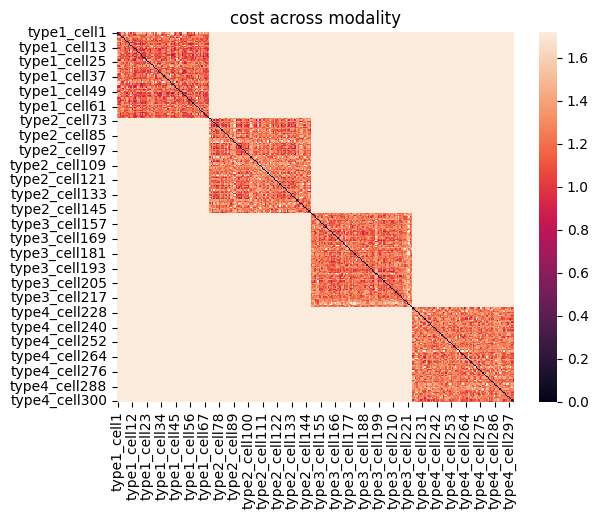

In [16]:
sns.heatmap(cost)
pl.title('cost across modality')

## solve the feature-guided optimal transport problem

In [ ]:
P_tensor = fgot_sparse_tensor(X1, X2, feature_matrix, cost,\
    ATAC_cluster, RNA_cluster, minibatch=0, device='cuda:3', eps_p = 1e-2)

## make multi-omics alignment from the transport tensor

In [18]:
P = fgot_tol(P_tensor)
P.shape

100%|██████████| 1212/1212 [00:00<00:00, 6242.29it/s]


(301, 301)

Text(0.5, 1.0, 'optimal transport matrix')

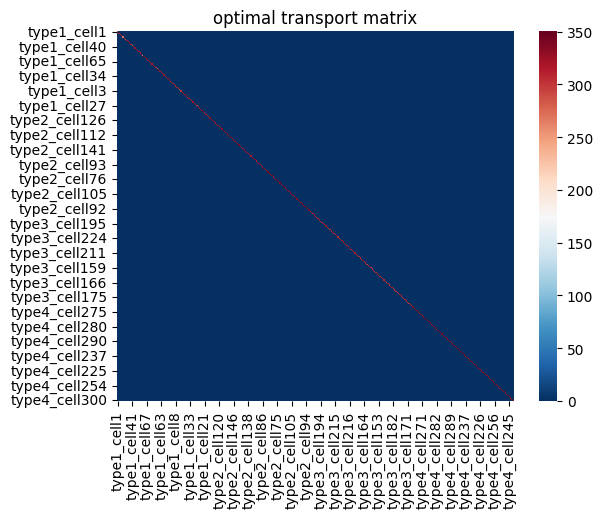

In [19]:
P_df = pd.DataFrame(P, index = cell_names1, columns = cell_names2)
sorted_cols = np.argsort(basic_labels1)
sorted_P = P_df.iloc[sorted_cols,: ]
sorted_rows = np.argsort(basic_labels2)
sorted_P = sorted_P.iloc[:, sorted_rows]
sns.heatmap(sorted_P, cmap="RdBu_r")
pl.title('optimal transport matrix')

In [20]:
X1_aligned, X2_aligned = align(X1, X2, P)

/home/yangchenghui/anaconda3/envs/env_FGOT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[<Axes: title={'center': 'batch'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'label'}, xlabel='UMAP1', ylabel='UMAP2'>]

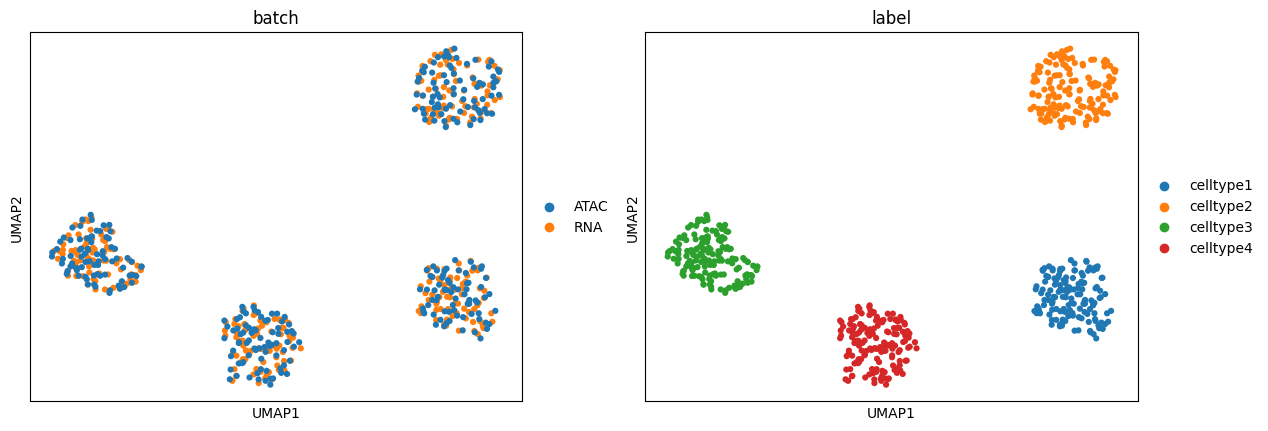

In [ ]:
data_aligned = np.concatenate((X2_aligned, X1_aligned), axis=0)
adata_aligned = AnnData(data_aligned)
adata_aligned.obs['batch'] = np.array(['RNA'] * n2 + ['ATAC'] * n1)
adata_aligned.obs['label'] = np.concatenate((basic_labels2, basic_labels1),axis=0)
sc.tl.pca(adata_aligned)
sc.pp.neighbors(adata_aligned, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_aligned)
sc.pl.umap(adata_aligned, color=['batch', 'label'],s = 80)

## infer the cell type specific regulatory intensity from the transport tensor

In [23]:
intensity_df = FGOT.fgot.fgot_analysis_link_intensity_for_each_celltype(P_tensor, feature_matrix, basic_labels1, basic_labels2, mode = 'ATAC2RNA')
intensity_df

100%|██████████| 110/110 [00:00<00:00, 117.85it/s]


,celltype2,celltype3,celltype4,celltype1
gene10-peak1,0.004836,0.001531,0.004126,0.003910
gene10-peak52,0.003988,0.001736,0.003727,0.002983
gene10-peak98,0.002192,0.000854,0.001872,0.002045
gene10-peak115,0.002975,0.005458,0.002155,0.003700
gene10-peak141,0.002162,0.000762,0.007245,0.002321
...,...,...,...,...
gene94-peak269,0.010201,0.000840,0.003408,0.000404
gene94-peak284,0.002873,0.003780,0.003219,0.000387
gene94-peak285,0.017852,0.000674,0.002269,0.000317
gene94-peak313,0.002449,0.001172,0.002415,0.000462


## 验证调控效果

In [24]:
def celltype_regulatory_pred(intensity_df, celltype, peak_gene_mt1):
    peak_gene_pred1 = pd.DataFrame(0.0, index=peak_gene_mt1.index, columns=peak_gene_mt1.columns)
    for idx, value in intensity_df[celltype].items():
        gene, peak = idx.split("-")
        if peak in peak_gene_pred1.index and gene in peak_gene_pred1.columns:
            peak_gene_pred1.loc[peak, gene] = value
    return peak_gene_pred1


def verify_regulatory_acc(peak_gene_true,peak_gene_pred):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import roc_auc_score, average_precision_score
    import matplotlib.pyplot as plt
    import seaborn as sns

    pred_mat = peak_gene_pred
    truth_mat = peak_gene_true

    results = []
    for gene in pred_mat.columns:
        y_score = pred_mat[gene].values
        if np.all(y_score == 0):
            continue
        y_true = truth_mat[gene].values
        if np.unique(y_true).size < 2:
            continue
        auc = roc_auc_score(y_true, y_score)
        auprc = average_precision_score(y_true, y_score)
        results.append({
            "gene": gene,
            "AUC": auc,
            "Normalized AUPRC": auprc/(np.sum(y_true)/len(y_true))
        })

    metrics_df = pd.DataFrame(results)
    return metrics_df

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar(metrics_df):
    plt.figure(figsize=(5, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=metrics_df["AUC"])
    plt.ylim(0.2, 1)
    plt.title("Gene-wise AUROC")

    plt.subplot(1, 2, 2)
    sns.boxplot(y=metrics_df["Normalized AUPRC"])
    plt.ylim(0, 200)
    plt.title("Gene-wise Normalized AUPRC")

    plt.tight_layout()
    plt.show()

celltype1

In [ ]:
peak_gene_pred1 = celltype_regulatory_pred(intensity_df,"celltype1",peak_gene_mt1)
metrics_df1 = verify_regulatory_acc(peak_gene_mt1,peak_gene_pred1)
metrics_df1

,gene,AUC,Normalized AUPRC
0,gene1,0.966565,27.500000
1,gene2,0.990881,82.500000
2,gene4,0.986280,41.250000
3,gene5,0.981763,47.142857
4,gene6,0.990881,82.500000
...,...,...,...
94,gene105,0.967988,20.192308
95,gene106,0.986280,45.833333
96,gene107,0.981763,47.142857
97,gene109,0.981763,47.142857


celltype2

In [ ]:
peak_gene_pred2 = celltype_regulatory_pred(intensity_df,"celltype2",peak_gene_mt2)
metrics_df2 = verify_regulatory_acc(peak_gene_mt2,peak_gene_pred2)
metrics_df2

,gene,AUC,Normalized AUPRC
0,gene1,0.983232,37.125000
1,gene3,0.986280,41.250000
2,gene4,0.969605,30.000000
3,gene5,0.972644,33.000000
4,gene6,0.969605,30.000000
...,...,...,...
92,gene106,0.978659,28.285714
93,gene107,0.978723,41.250000
94,gene108,0.993921,110.000000
95,gene109,0.990881,82.500000


celltype3

In [ ]:
peak_gene_pred3 = celltype_regulatory_pred(intensity_df,"celltype3",peak_gene_mt3)
metrics_df3 = verify_regulatory_acc(peak_gene_mt3,peak_gene_pred3)
metrics_df3

,gene,AUC,Normalized AUPRC
0,gene1,0.995427,115.500000
1,gene4,1.000000,330.000000
2,gene5,0.990881,82.500000
3,gene6,0.975610,25.312500
4,gene7,0.978659,28.645833
...,...,...,...
96,gene106,0.978723,41.250000
97,gene107,0.993921,110.000000
98,gene108,0.987805,44.000000
99,gene109,0.983232,55.000000


celltype4

In [ ]:
peak_gene_pred4 = celltype_regulatory_pred(intensity_df,"celltype4",peak_gene_mt4)
metrics_df4 = verify_regulatory_acc(peak_gene_mt4,peak_gene_pred4)
metrics_df4

,gene,AUC,Normalized AUPRC
0,gene1,0.984802,55.000000
1,gene2,0.981763,47.142857
2,gene3,0.993902,110.000000
3,gene4,0.977134,26.812500
4,gene5,0.990854,55.000000
...,...,...,...
97,gene106,0.986280,40.071429
98,gene107,0.981763,47.142857
99,gene108,0.975684,36.666667
100,gene109,0.969605,30.000000
